# Analysis

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import ptitprince as pt
import pickle as pkl
from src.data.analyse import *
from src.data.visualise import *
from tqdm import tqdm
from ema_workbench import load_results
import plotly.express as px
sns.set_theme(style="ticks")

## Load results

In [17]:
# Load results
n_scenarios = 3000
n_policies = 0
results = load_results(f'../results/scenarios={n_scenarios}, policies={n_policies}.tar.gz')

# Prepare outcomes
outcomes = prepare_outcomes(results, add_policies=False)

## Verification & EDA

To be verified:
- `n_new_poor` V
- `n_new_poor_pct` V
- `new_poverty_gap` V
- `annual_average_consumption_loss_pct` V
- `r` V
- `years_in_poverty` X 

### Single scenario, single district 

In [6]:
# Print all outcomes for a single scenario
scenario = 0
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)
numeric_columns = outcomes.columns[3:-1].tolist()
df[numeric_columns].round(2).style.format("{:,.2f}")

,total_population,total_asset_loss,total_consumption_loss,event_damage,total_asset_stock,average_productivity,total_asset_in_survey,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,recovery_rate
district,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"8,666.91","1,286,739.33","2,312,287.82","1,282,936.18","47,442,177.05",0.48,"334,331,195.84",0.03,504.94,"1,591.22",914.27,"1,282,936.18","3,292.00",148.00,66.00,32.85,33.29,457.93,21.94,0.55,0.50
Castries,"70,959.09","30,801,632.38","40,346,949.13","31,062,668.40","1,587,405,663.34",0.30,"3,435,721,049.12",0.02,"3,522.78","6,213.45","2,976.86","31,062,668.40","15,948.00",834.00,360.00,34.78,34.31,"1,145.31",20.97,0.77,0.27
Choiseul,"5,475.87","1,098,187.34","1,700,936.66","1,111,847.84","54,354,802.37",0.19,"377,890,219.98",0.02,336.19,"1,932.86",926.75,"1,111,847.84",923.00,61.00,69.00,26.55,25.15,505.95,28.84,0.65,0.26
Dennery,"11,590.78","2,725,454.41","5,916,123.43","2,667,414.34","125,372,604.01",0.56,"417,528,403.13",0.02,848.64,"3,383.57","1,934.66","2,667,414.34","5,216.00",517.00,0.00,23.52,23.52,697.13,23.89,0.45,0.38
Gros Islet,"27,467.06","10,791,459.60","7,841,687.48","10,932,607.53","532,061,766.39",0.28,"3,294,339,146.51",0.02,"1,551.77","2,841.95","1,040.60","10,932,607.53","3,245.00",314.00,148.00,15.39,14.87,505.34,16.05,1.39,0.22
Laborie,"6,828.32","2,071,032.81","4,355,146.70","2,035,118.22","99,235,698.32",0.35,"215,695,044.06",0.02,361.41,"5,123.26","2,964.26","2,035,118.22","1,599.00",0.00,0.00,23.26,23.26,"1,205.03",22.68,0.47,0.36
Micoud,"17,435.51","4,825,613.47","8,190,896.77","4,766,541.74","231,995,156.10",0.32,"554,020,360.02",0.02,812.98,"6,056.25","2,698.00","4,766,541.74","5,433.00",139.00,96.00,38.18,37.77,"1,007.52",5.73,0.58,0.29
Soufriere,"8,985.05","1,675,036.86","1,231,117.82","1,679,254.31","82,756,712.06",0.23,"535,928,432.44",0.02,430.98,"2,953.40",994.91,"1,679,254.31","2,295.00",0.00,0.00,31.47,31.47,285.65,1.38,1.36,0.16
Vieuxfort,"15,229.37","4,208,777.63","7,583,004.51","4,264,030.49","216,534,648.76",0.32,"1,266,550,258.12",0.02,"1,236.31","2,121.05","1,101.52","4,264,030.49","5,272.00",283.00,349.00,23.35,22.56,613.36,28.56,0.56,0.33


In [7]:
# Let's examine a single scenario in details
scenario = 4
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)

# And a single district as an example
district = 'Anse-La-Raye & Canaries'
total_population = round(df.loc[district, 'total_population'])
n_affected = round(df.loc[district, 'n_affected_people'])
print('Total population: ', total_population)
print('Number of affected people: ', n_affected)

n_poor_initial = round(df.loc[district, 'n_poor_initial'])
n_new_poor = round(df.loc[district, 'n_new_poor'])
pct_poor_initial = round(n_poor_initial / total_population * 100, 2)
pct_new_poor = round((n_new_poor + n_poor_initial) / total_population * 100, 2)
pct_poor_increase = round(n_new_poor / total_population * 100, 2)
initial_poverty_gap = round(df.loc[district, 'initial_poverty_gap'], 2)
new_poverty_gap = round(df.loc[district, 'new_poverty_gap'], 2)
print()
print('Number of poor: ', n_poor_initial)
print('Number of new poor: ', n_new_poor)
print(f'Percentage of poor: {pct_poor_initial}%')
print(f'Percentage of new poor: {pct_new_poor}%')
print(f'Percentage of increase in poor: {pct_poor_increase}%')
print('Initial poverty gap: ', initial_poverty_gap)
print('New poverty gap: ', new_poverty_gap)

annual_average_consumption = round(df.loc[district, 'annual_average_consumption'])
annual_average_consumption_loss = round(df.loc[district, 'annual_average_consumption_loss'])
annual_average_consumption_loss_pct = round(df.loc[district, 'annual_average_consumption_loss_pct'])
print()

print('Annual average consumption: ', annual_average_consumption)
print('Annual average consumption loss: ', annual_average_consumption_loss)
print(f'Annual average consumption loss percentage: {annual_average_consumption_loss_pct}%')

print()
r = round(df.loc[district, 'r'], 2)
print('Socio-economic resilience: ', r)

Total population:  8667
Number of affected people:  932

Number of poor:  3292
Number of new poor:  0
Percentage of poor: 37.98%
Percentage of new poor: 37.98%
Percentage of increase in poor: 0.0%
Initial poverty gap:  32.85
New poverty gap:  32.85

Annual average consumption:  1591
Annual average consumption loss:  178
Annual average consumption loss percentage: 12%

Socio-economic resilience:  0.77


### Multiple scenarios & multiple districts

In [64]:
columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '>10']
index = ['Anse-La-Raye & Canaries', 'Castries', 'Choiseul', 'Dennery', 'Gros Islet', 'Laborie', 'Micoud', 'Soufriere', 'Vieuxfort']
average_years_in_poverty = pd.DataFrame(columns=columns, index=index)
average_years_in_poverty = average_years_in_poverty.fillna(0)
n_scenarios = outcomes['scenario'].unique().size
for scenario in tqdm(outcomes['scenario'].unique()):
    df = outcomes[outcomes['scenario'] == scenario]
    df.set_index('district', inplace=True)
    years_in_poverty = pd.DataFrame(columns=columns)
    for index, row in df.iterrows():
        x = row['years_in_poverty']
        for key, values in x.items():
            if key == 10:
                key_value = ">10"
            else:
                key_value = str(key)
            years_in_poverty.loc[index, key_value] = int(values)
    average_years_in_poverty += years_in_poverty
average_years_in_poverty = average_years_in_poverty / n_scenarios
average_years_in_poverty

100%|██████████| 3000/3000 [00:39<00:00, 76.19it/s]


,0,1,2,3,4,5,6,7,8,9,>10
Anse-La-Raye & Canaries,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.084667
Castries,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.512667,6.497,537.134
Choiseul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.726333
Dennery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.096333
Gros Islet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,211.690333
Laborie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167333,48.010333
Micoud,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017333,82.547333
Soufriere,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.299667
Vieuxfort,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.243667


In [65]:
# Let's check whether the numbers add up
outcomes[['district', 'n_new_poor']].groupby(['district']).mean()['n_new_poor']

district
Anse-La-Raye & Canaries     79.084667
Castries                   544.145000
Choiseul                    72.726333
Dennery                     58.096333
Gros Islet                 211.690333
Laborie                     48.177333
Micoud                      82.564667
Soufriere                  102.299667
Vieuxfort                  263.243667
Name: n_new_poor, dtype: float64

In [8]:
# Let's aggregate across scenarios and take the mean
outcomes.iloc[:, 2:-1].groupby('district').mean(numeric_only=True).round(2).style.format("{:,.2f}")

,total_population,total_asset_loss,total_consumption_loss,event_damage,total_asset_stock,average_productivity,total_asset_in_survey,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,recovery_rate
district,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"8,666.91","1,281,890.16","2,025,411.36","1,282,936.18","47,442,177.05",0.48,"334,331,195.84",0.03,654.92,"1,591.22",914.27,"1,282,936.18","3,292.00",236.07,79.08,32.85,32.61,350.06,20.06,0.66,0.42
Castries,"70,959.09","31,068,469.82","45,959,779.88","31,062,668.40","1,587,405,663.34",0.30,"3,435,721,049.12",0.02,"3,130.30","6,213.45","2,976.86","31,062,668.40","15,948.00",701.53,544.14,34.78,34.54,"1,543.42",24.75,0.69,0.26
Choiseul,"5,475.87","1,111,455.88","1,622,248.62","1,111,847.84","54,354,802.37",0.19,"377,890,219.98",0.02,268.16,"1,932.86",926.75,"1,111,847.84",923.00,44.57,72.73,26.55,26.52,699.46,34.08,0.70,0.20
Dennery,"11,590.78","2,666,280.68","3,999,426.38","2,667,414.34","125,372,604.01",0.56,"417,528,403.13",0.02,605.42,"3,383.57","1,934.66","2,667,414.34","5,216.00",272.27,58.10,23.52,23.49,772.73,22.37,0.71,0.52
Gros Islet,"27,467.06","10,922,720.84","13,880,659.62","10,932,607.53","532,061,766.39",0.28,"3,294,339,146.51",0.02,"1,481.71","2,841.95","1,040.60","10,932,607.53","3,245.00",139.94,211.69,15.39,16.08,"1,047.71",30.85,0.84,0.24
Laborie,"6,828.32","2,033,795.25","3,656,250.83","2,035,118.22","99,235,698.32",0.35,"215,695,044.06",0.02,322.65,"5,123.26","2,964.26","2,035,118.22","1,599.00",75.93,48.18,23.26,23.22,"1,440.18",24.95,0.58,0.32
Micoud,"17,435.51","4,767,821.10","7,695,688.33","4,766,541.74","231,995,156.10",0.32,"554,020,360.02",0.02,835.44,"6,056.25","2,698.00","4,766,541.74","5,433.00",258.70,82.56,38.18,37.91,"1,031.53",17.53,0.66,0.29
Soufriere,"8,985.05","1,679,108.73","2,562,642.86","1,679,254.31","82,756,712.06",0.23,"535,928,432.44",0.02,458.96,"2,953.40",994.91,"1,679,254.31","2,295.00",115.47,102.30,31.47,31.50,653.52,28.72,0.68,0.17
Vieuxfort,"15,229.37","4,258,723.75","6,575,480.25","4,264,030.49","216,534,648.76",0.32,"1,266,550,258.12",0.02,"1,058.34","2,121.05","1,101.52","4,264,030.49","5,272.00",331.61,263.24,23.35,23.60,676.62,31.31,0.67,0.28


In [ ]:
columns_of_interest = ['total_asset_loss', 
                       'total_consumption_loss', 
                       'n_affected_people',
                       'new_poverty_gap',
                       'annual_average_consumption_loss',
                       'annual_average_consumption_loss_pct',
                       'r']

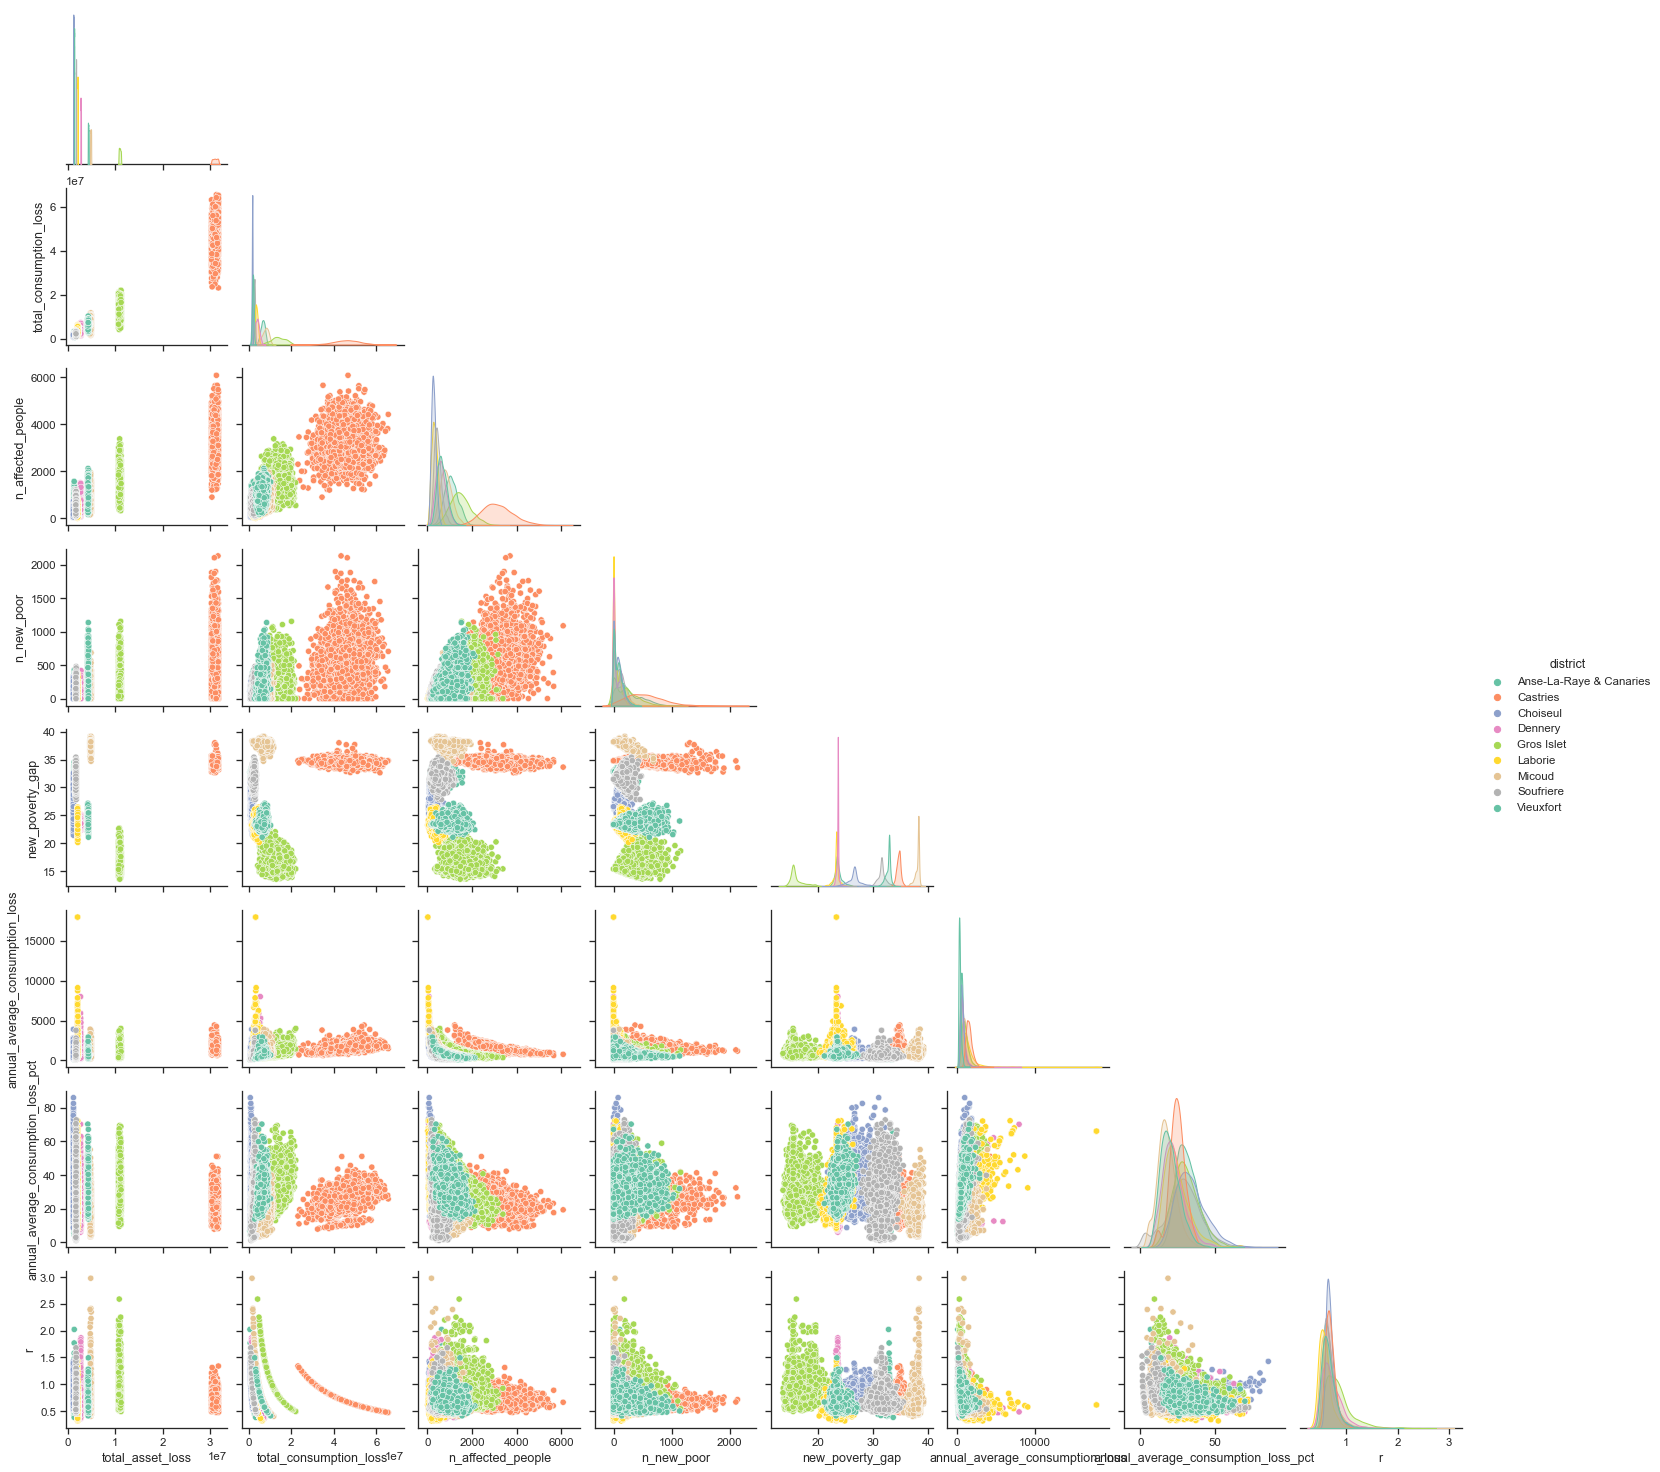

In [67]:
df = outcomes[['district'] + columns_of_interest]
sns.pairplot(df, hue='district', palette='Set2', corner=True);

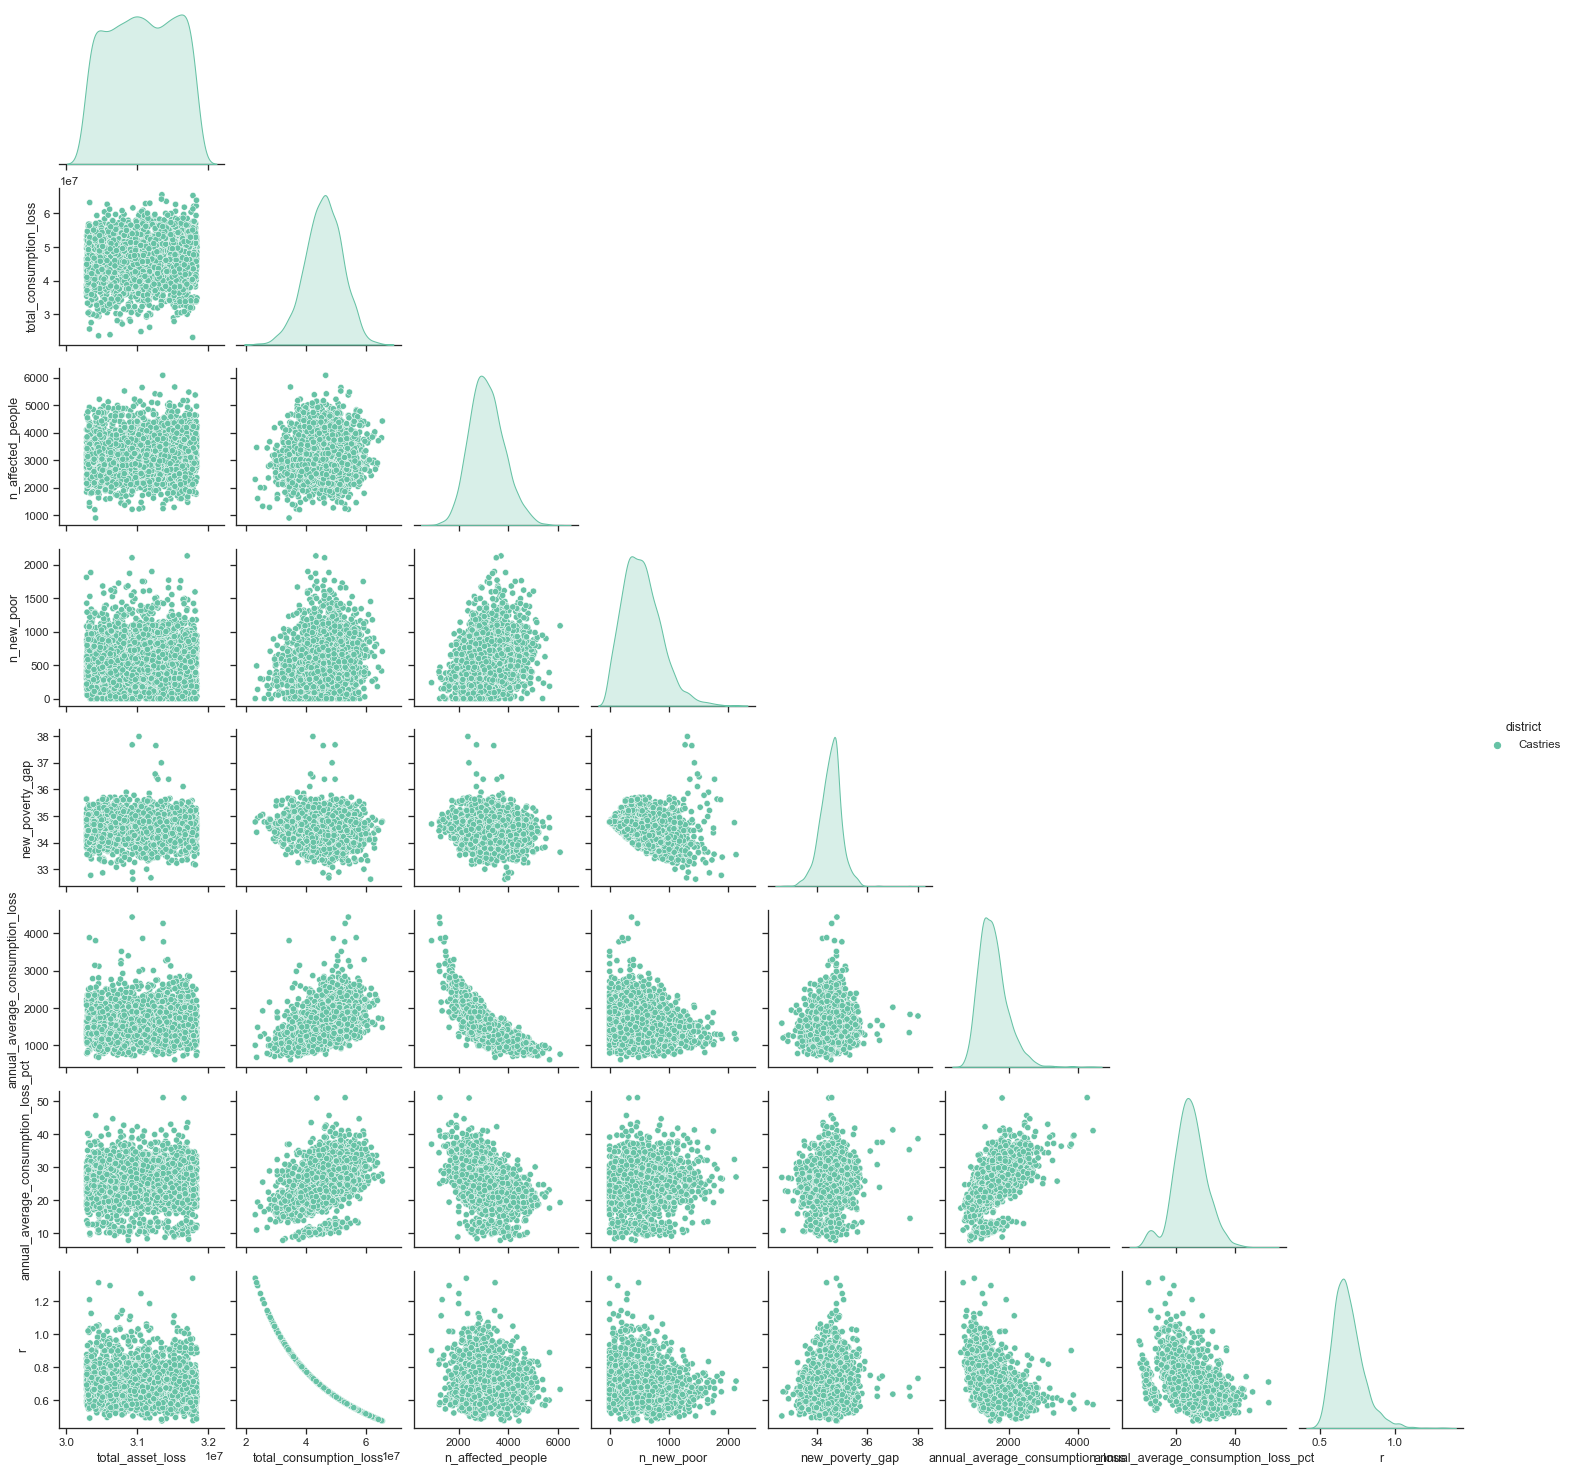

In [68]:
df = outcomes[['district'] + columns_of_interest]
sns.pairplot(df[df['district'] == 'Castries'], hue='district', palette='Set2', corner=True);

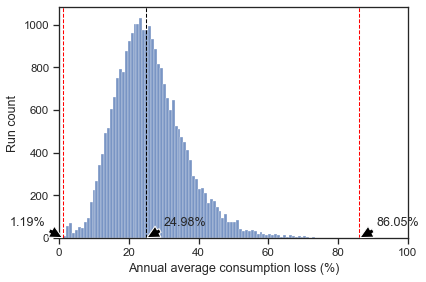

In [69]:
sns.histplot(outcomes['annual_average_consumption_loss_pct'])
plt.xlabel('Annual average consumption loss (%)')
plt.ylabel('Run count')
plt.xlim(0, 100);
plt.savefig('../figures/analysis/annual_average_consumption_loss_pct.png')
# Add min and max values
plt.axvline(outcomes['annual_average_consumption_loss_pct'].min(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(outcomes['annual_average_consumption_loss_pct'].max(), color='red', linestyle='dashed', linewidth=1)
# Add median value
plt.axvline(outcomes['annual_average_consumption_loss_pct'].median(), color='black', linestyle='dashed', linewidth=1)
# Annotate min and max values
plt.annotate(f"{outcomes['annual_average_consumption_loss_pct'].min():.2f}%",
                xy=(outcomes['annual_average_consumption_loss_pct'].min(), 0),
                xytext=(outcomes['annual_average_consumption_loss_pct'].min() - 5, 100),
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='top')
plt.annotate(f"{outcomes['annual_average_consumption_loss_pct'].max():.2f}%",
                xy=(outcomes['annual_average_consumption_loss_pct'].max(), 0),
                xytext=(outcomes['annual_average_consumption_loss_pct'].max() + 5, 100),
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left', verticalalignment='top')
# Annotate median value
plt.annotate(f"{outcomes['annual_average_consumption_loss_pct'].median():.2f}%",
                xy=(outcomes['annual_average_consumption_loss_pct'].median(), 0),
                xytext=(outcomes['annual_average_consumption_loss_pct'].median() + 5, 100),
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left', verticalalignment='top');
# plt.savefig('../figures/analysis/annual_average_consumption_loss_pct_with_min_max.png')

In [70]:
outcomes['annual_average_consumption_loss_pct'].describe()

count    27000.000000
mean        26.067001
std         10.073928
min          1.194148
25%         19.141382
50%         24.976216
75%         31.789605
max         86.052477
Name: annual_average_consumption_loss_pct, dtype: float64

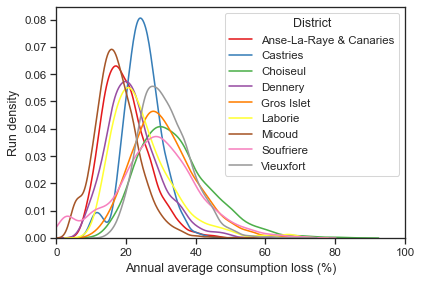

In [71]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots()
colors = sns.color_palette('Set1', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    color = colors[districts.index(district)]
    # sns.histplot(data=df, x='annual_average_consumption_loss_pct', ax=ax, color=color, multiple='stack')
    sns.kdeplot(data=df, x='annual_average_consumption_loss_pct', ax=ax, color=color)
    ax.set_xlabel('Annual average consumption loss (%)')
    ax.set_ylabel('Run density')
ax.set_xlim(0, 100)
ax.legend(districts, title='District');

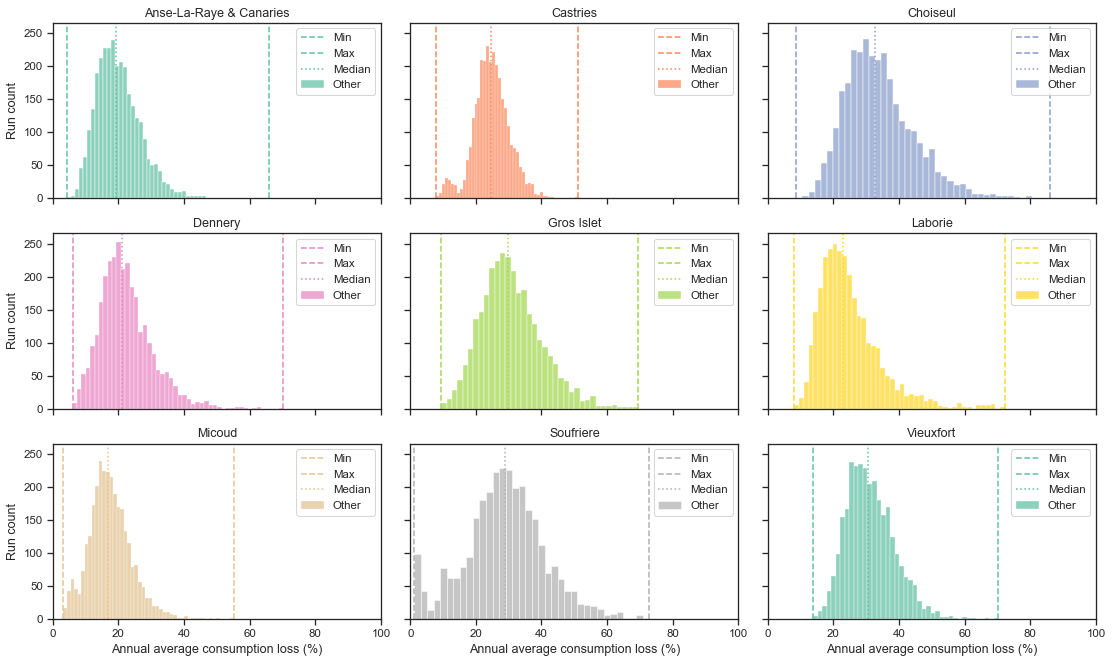

In [72]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    sns.histplot(data=df, x='annual_average_consumption_loss_pct', ax=ax[i, j], multiple='stack', color=color)
    ax[i, j].set_title(district)
    ax[i, j].set_xlabel('Annual average consumption loss (%)')
    ax[i, j].set_ylabel('Run count')
    ax[i, j].set_xlim(0, 100)
    ax[i, j].axvline(df['annual_average_consumption_loss_pct'].min(), color=color, linestyle='--')
    ax[i, j].axvline(df['annual_average_consumption_loss_pct'].max(), color=color, linestyle='--')
    ax[i, j].axvline(df['annual_average_consumption_loss_pct'].median(), color=color, linestyle=':')
    ax[i, j].legend(['Min', 'Max', 'Median', 'Other'])
fig.tight_layout()

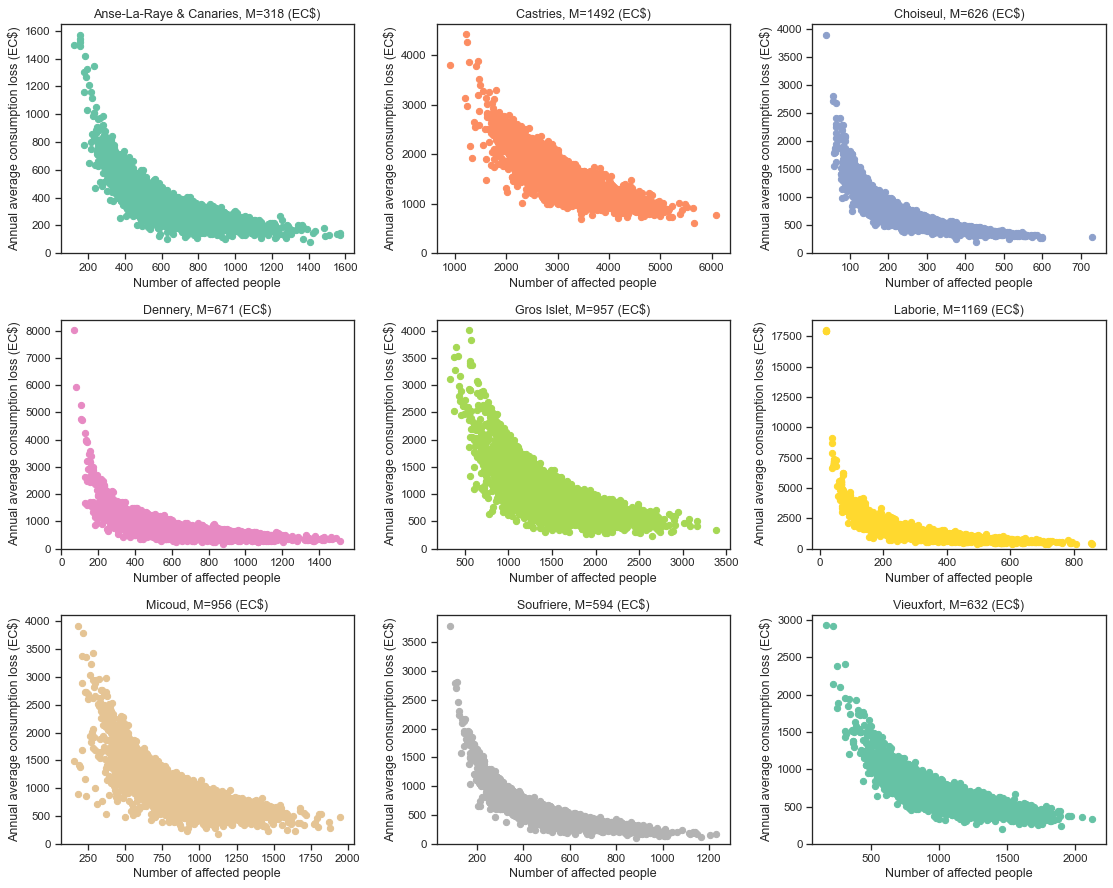

In [73]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=False)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['n_affected_people']
    y = df['annual_average_consumption_loss']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Number of affected people')
    ax[i, j].set_ylabel('Annual average consumption loss (EC$)')
    ax[i, j].set_ylim(0)
    ax[i, j].set_title(f'{district}, M={df["annual_average_consumption_loss"].median():.0f} (EC$)')

fig.tight_layout();

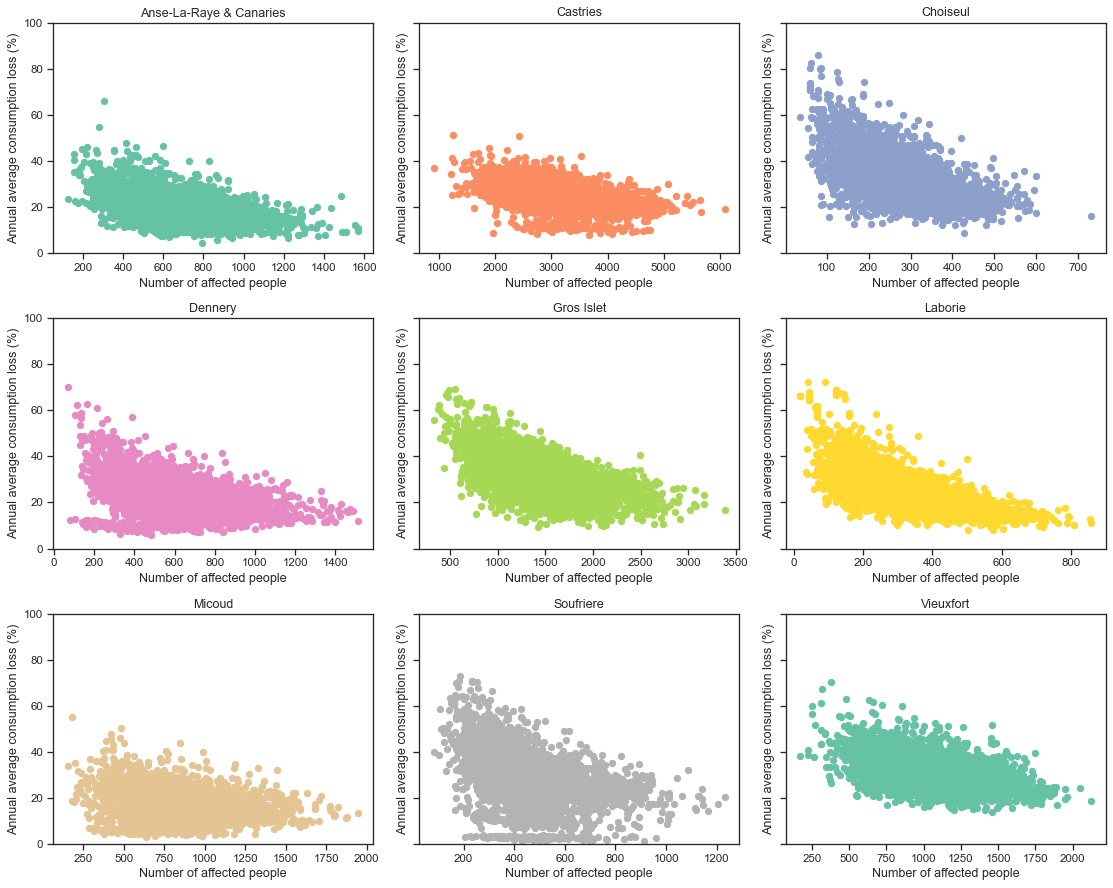

In [74]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['n_affected_people']
    y = df['annual_average_consumption_loss_pct']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Number of affected people')
    ax[i, j].set_ylabel('Annual average consumption loss (%)')
    ax[i, j].set_ylim(0, 100)
    ax[i, j].set_title(district)

fig.tight_layout();

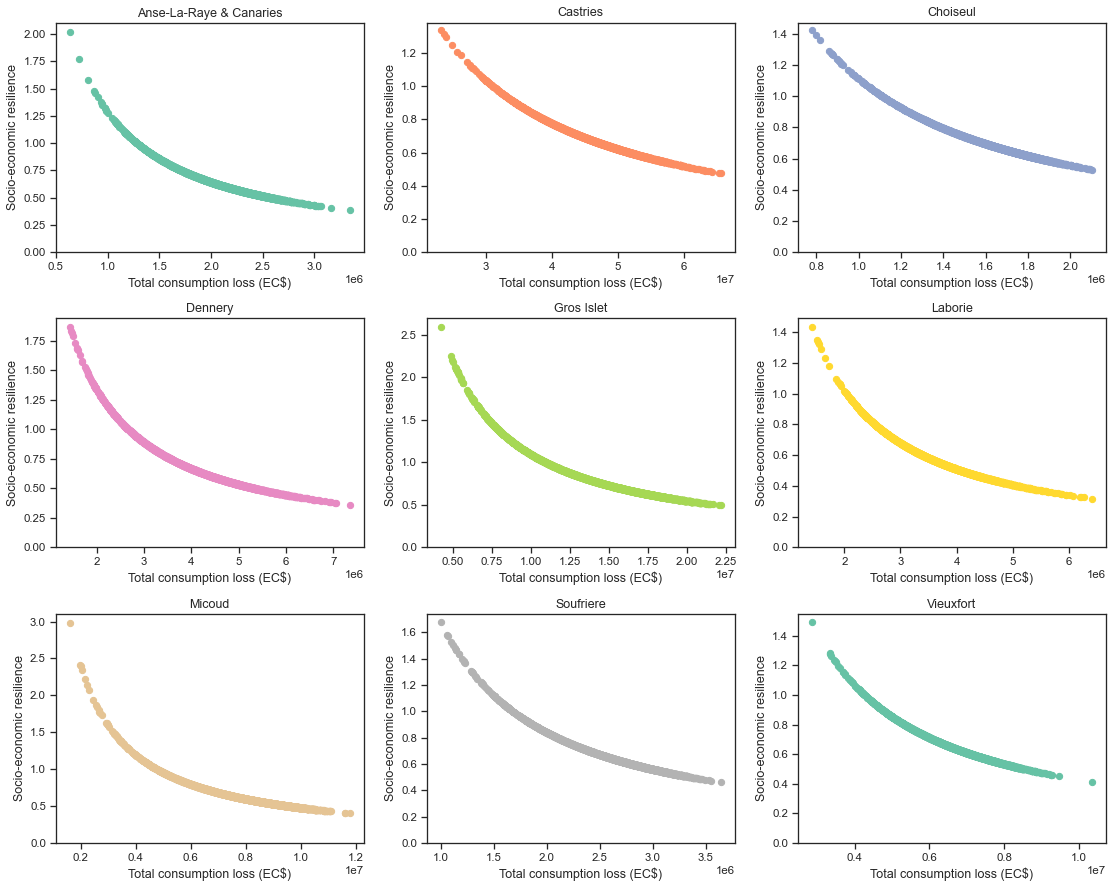

In [75]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 4 * n_districts / 3), sharex=False, sharey=False)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    x = df['total_consumption_loss']
    y = df['r']
    ax[i, j].scatter(x, y, color=color)
    ax[i, j].set_xlabel('Total consumption loss (EC$)')
    ax[i, j].set_ylabel('Socio-economic resilience')
    ax[i, j].set_ylim(0)
    ax[i, j].set_title(district)

fig.tight_layout();

## Raincloud plots

Raincloud plot is a combination of a boxplot, a kernel density plot, and a dot plot. It is a great way to visualize the distribution of the data. Especially, when the distribution is skewed and you have a lot of data points.

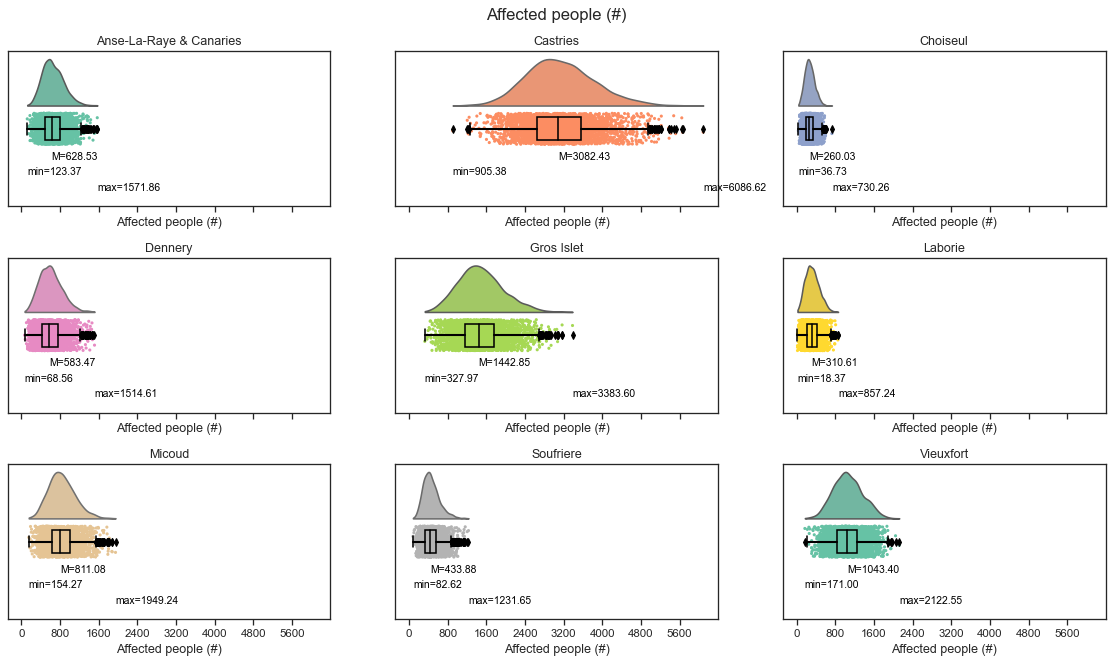

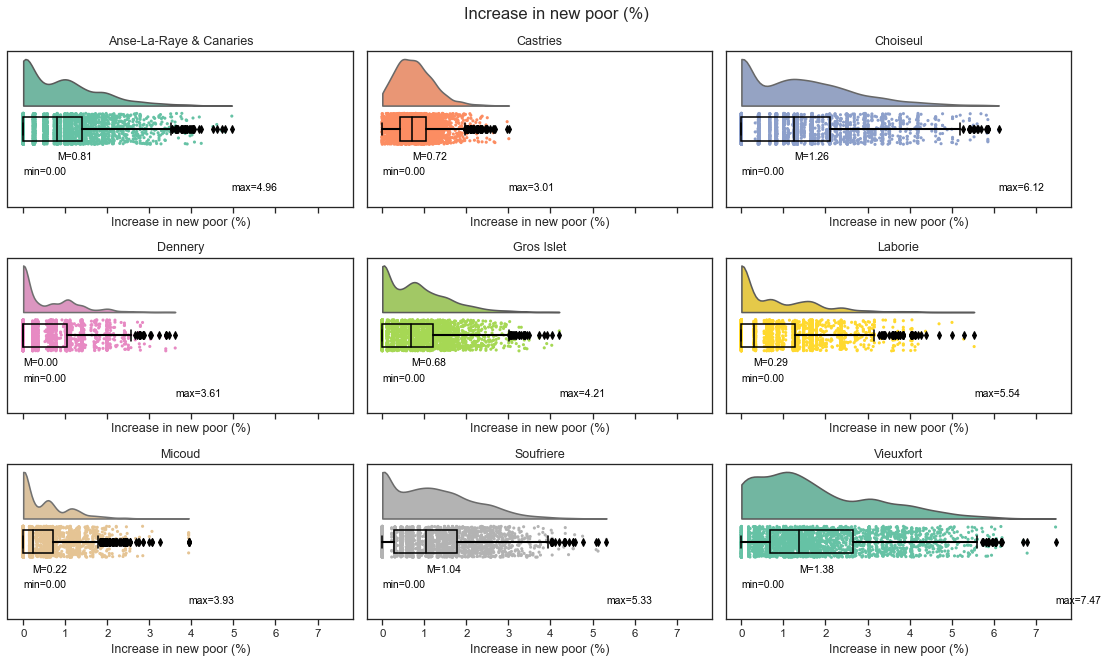

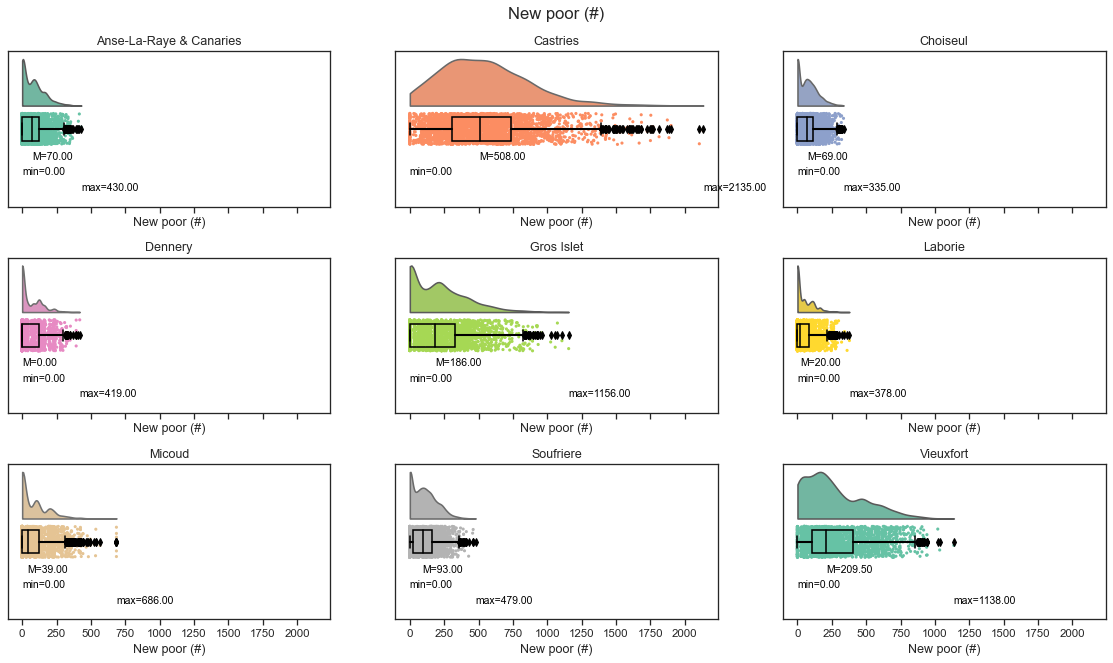

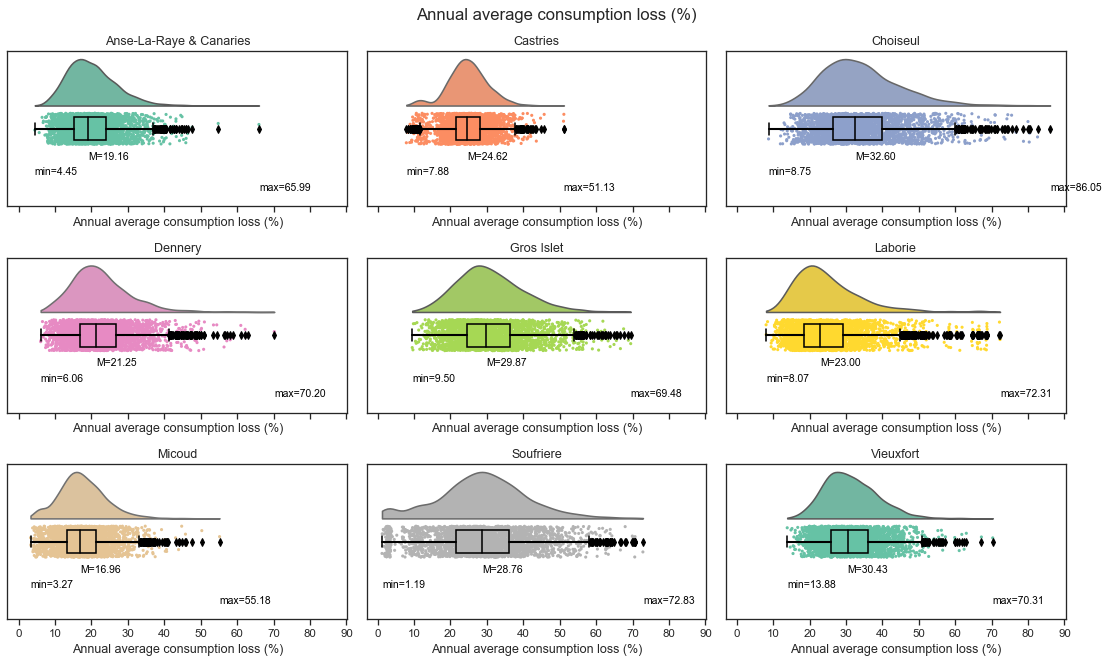

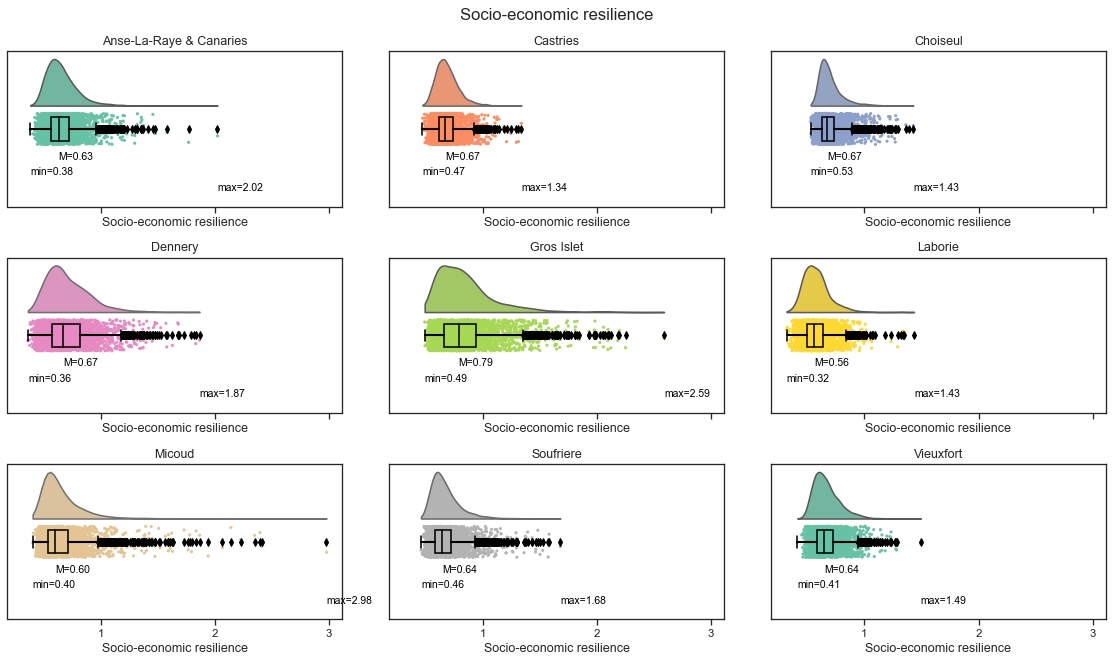

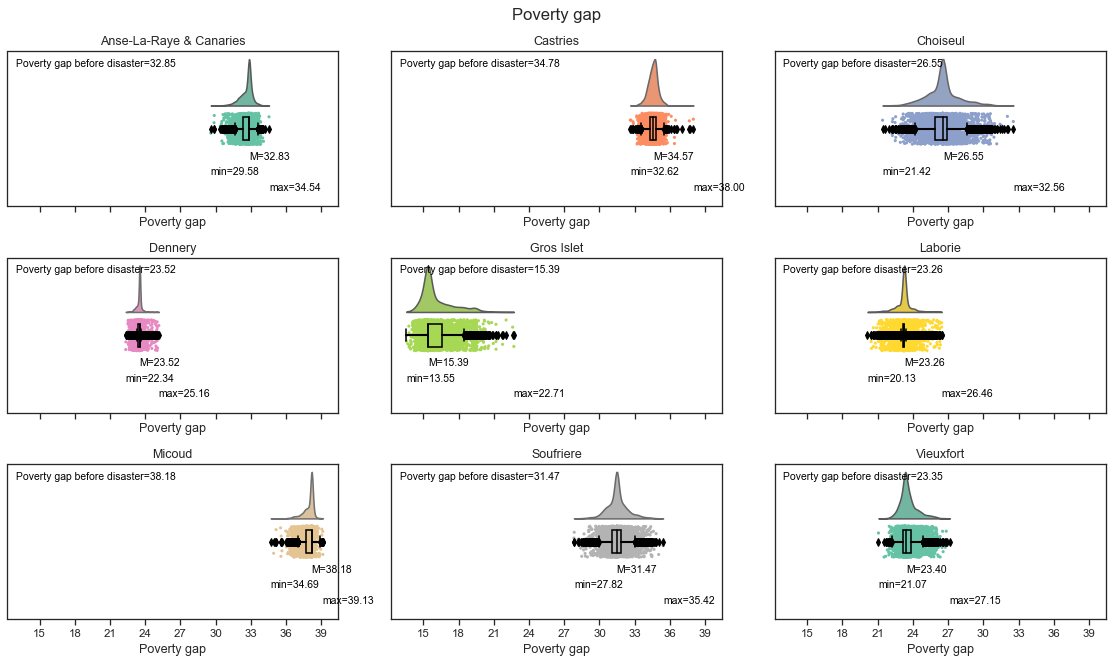

In [9]:
rainclouds(outcomes, savefig=False)

## Choropleth maps

Another way to visualize the outcomes is to use choropleth maps. These maps are useful when you have data that is aggregated by a geographic area. For example, if we have data on how many people became poor after a disaster in the districts of Saint Lucia, we could use a choropleth map to show these numbers.  

What is important to remember is that **these maps do not show the variance** within each district. Instead, they show the mean or median value for each district.

In [22]:
# Get the country shapefile and aggregated outcomes
country = gpd.read_file('../data/raw/shapefiles/Saint Lucia/gadm36_LCA_shp/gadm36_LCA_0.shp')
aggregation = 'mean'
aggregated_outcomes = get_spatial_outcomes(outcomes, aggregation=aggregation)

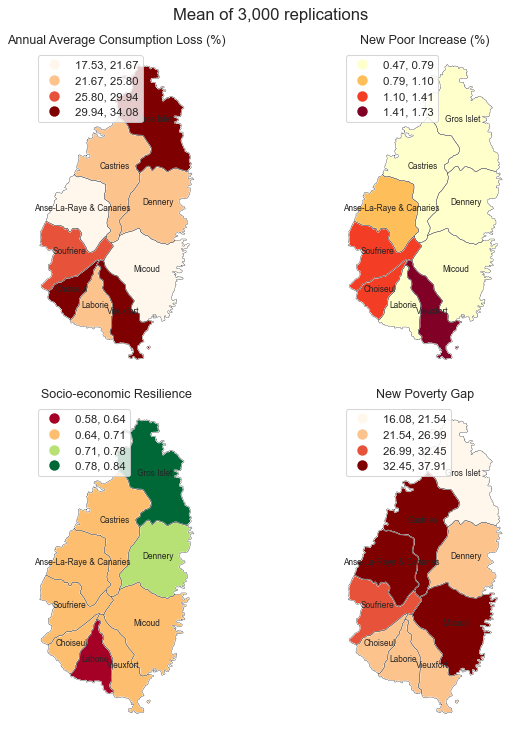

In [23]:
# Plot the outcomes in a 2 by 2 grid
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
outcomes_to_plot = ['annual_average_consumption_loss_pct', 'n_new_poor_increase_pct', 'r', 'new_poverty_gap']
titles = ['Annual Average Consumption Loss (%)', 'New Poor Increase (%)', 'Socio-economic Resilience', 'New Poverty Gap']
cmaps = ['OrRd', 'YlOrRd', 'RdYlGn', 'OrRd']
for i, outcome in enumerate(outcomes_to_plot): 
    aggregated_outcomes.plot(column=outcome, scheme='equalinterval', cmap=cmaps[i], k=4, ax=ax[i//2, i%2], legend=True, legend_kwds={"loc" : "upper left"})
    aggregated_outcomes.plot(ax=ax[i//2, i%2], color='none', edgecolor='black', linewidth=0.25)
    ax[i//2, i%2].set_title(titles[i])
    ax[i//2, i%2].axis('off')
    for idx, row in aggregated_outcomes.iterrows():
        ax[i//2, i%2].annotate(text=row['NAME_1'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
fig.suptitle(f'{aggregation.capitalize()} of 3,000 replications', fontsize=16)
fig.tight_layout()

A bivariate or bi-variate choropleth helps to visualise relations between two variables spatially. 

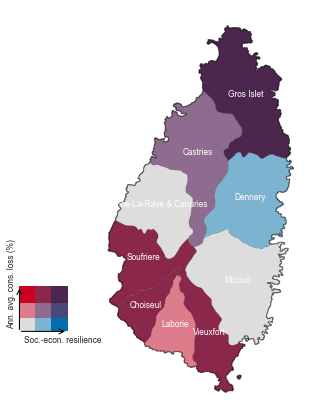

In [24]:
x_name = 'r'
y_name = 'annual_average_consumption_loss_pct'
x_label = 'Soc.-econ. resilience'
y_label = 'Ann. avg. cons. loss (%)'

bivariate_choropleth(aggregated_outcomes, x_name, y_name, x_label, y_label, scale=True, figsize=(7,6))